In [1]:
import numpy as np
import pandas as pd   
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.utils import resample
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 1. 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 2. 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# 3. current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 4. 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 5. 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# 6. 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 7. 상관계수 높은 변수 사전 삭제
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat', 'peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')

# -------------------------
# 8. grade 불균형 교정 (혼합 샘플링)
# -------------------------
if 'grade' in df.columns:
    print("\n📊 원본 grade 분포:")
    print(df['grade'].value_counts().sort_index())

    # 학년별 데이터 분리
    df_1 = df[df['grade'] == 1]
    df_2 = df[df['grade'] == 2]
    df_3 = df[df['grade'] == 3]
    df_4 = df[df['grade'] == 4]

    # 목표 샘플 수 설정 (균형 맞추기)
    target_n = 110

    # 과소/과대표집 수행
    df_1_down = resample(df_1, replace=False, n_samples=target_n, random_state=RANDOM_STATE)  # 과소표집
    df_2_up   = resample(df_2, replace=True,  n_samples=target_n, random_state=RANDOM_STATE)  # 과대표집
    df_3_up   = resample(df_3, replace=True,  n_samples=target_n, random_state=RANDOM_STATE)  # 과대표집
    df_4_up   = resample(df_4, replace=True,  n_samples=target_n, random_state=RANDOM_STATE)  # 과대표집

    # 병합
    df = pd.concat([df_1_down, df_2_up, df_3_up, df_4_up], axis=0).reset_index(drop=True)

    print("\n✅ 균형조정 후 grade 분포:")
    print(df['grade'].value_counts().sort_index())

# -------------------------
# 9. sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 10. 설명용 출력
# -------------------------
print("\n✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group', 'grade']].head())



📊 원본 grade 분포:
grade
1    176
2     95
3     29
4     55
Name: count, dtype: int64

✅ 균형조정 후 grade 분포:
grade
1    110
2    110
3    110
4    110
Name: count, dtype: int64

✅ 최종 데이터셋 컬럼 수: 178
sat 중위수: 4.0
    sat  sat_group  grade
0  4.00          1      1
1  3.25          0      1
2  3.75          0      1
3  4.00          1      1
4  5.00          1      1


In [2]:
import pandas as pd
from scipy.stats import skew, kurtosis, ttest_ind

# 0/1 집단 분리
group1 = df[df['sat_group'] == 1]['sat']
group0 = df[df['sat_group'] == 0]['sat']

# 요약 통계 계산
summary = {
    "group": ["전체", "0집단", "1집단"],
    "n": [df['sat'].count(), group0.count(), group1.count()],
    "mean": [df['sat'].mean(), group0.mean(), group1.mean()],
    "std": [df['sat'].std(), group0.std(), group1.std()],
    "skew": [skew(df['sat']), skew(group0), skew(group1)],
    "kurtosis": [kurtosis(df['sat']), kurtosis(group0), kurtosis(group1)]
}

summary_df = pd.DataFrame(summary).round(3)

# t-test (독립표본)
t_stat, p_val = ttest_ind(group1, group0, equal_var=False)  # Welch’s t-test (이분산 가정)

print("=== sat 요약 통계 ===")
print(summary_df)
print("\n=== 집단 간 T-검정 결과 ===")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


=== sat 요약 통계 ===
  group    n   mean    std   skew  kurtosis
0    전체  440  3.848  1.002 -0.792     0.382
1   0집단  183  2.887  0.733 -1.330     1.142
2   1집단  257  4.532  0.458 -0.102    -1.835

=== 집단 간 T-검정 결과 ===
t = 26.859, p = 0.0000


In [48]:
import pandas as pd
import numpy as np
from scipy import stats

# -------------------------
# 1️⃣ 그룹 분리
# -------------------------
group0 = df[df['sat_group'] == 0]  # 저만족
group1 = df[df['sat_group'] == 1]  # 고만족

# -------------------------
# 2️⃣ 변수 자동 분류
# -------------------------
# 0/1만 존재 → 명목형(이진/원핫)
nominal_vars = [c for c in df.columns 
                if df[c].dropna().nunique() == 2 
                and c not in ['sat_group', 'sat', 'grade']]

# 숫자형 + 값 개수 3 이상 → 순서형(리커트 척도)
ordinal_vars = [c for c in df.select_dtypes(include=np.number).columns 
                if c not in nominal_vars + ['sat_group', 'sat', 'grade']]

# -------------------------
# 3️⃣ 순서형 변수 t검정
# -------------------------
t_test_results = []
for col in ordinal_vars:
    data0 = group0[col].dropna()
    data1 = group1[col].dropna()
    if len(data0) < 2 or len(data1) < 2:  # 샘플 너무 적으면 건너뜀
        continue
    
    t_stat, p_val = stats.ttest_ind(data0, data1, equal_var=False)
    
    if p_val < 0.05:
        t_test_results.append({
            "variable": col,
            "group0_mean": data0.mean(),
            "group1_mean": data1.mean(),
            "t_stat": t_stat,
            "p_value": p_val
        })

t_test_df = pd.DataFrame(t_test_results).sort_values("p_value")
print("=== 유의한 순서형 변수 t검정 결과 ===")
display(t_test_df)

# -------------------------
# 4️⃣ 명목형 변수 카이검정
# -------------------------
chi2_results = []
for col in nominal_vars:
    contingency = pd.crosstab(df[col], df['sat_group'])
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        continue
    
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    
    if p < 0.05:
        chi2_results.append({
            "variable": col,
            "chi2": chi2,
            "dof": dof,
            "p_value": p,
            "group0_count": contingency[0].to_dict(),
            "group1_count": contingency[1].to_dict()
        })

chi2_df = pd.DataFrame(chi2_results).sort_values("p_value")
print("=== 유의한 명목형 변수 카이검정 결과 ===")
display(chi2_df)


=== 유의한 순서형 변수 t검정 결과 ===


,variable,group0_mean,group1_mean,t_stat,p_value
62,univ_proud,2.688525,4.428016,-24.610923,4.581000e-78
61,univ_belong,2.896175,4.498054,-21.452755,3.874191e-62
60,major_proud,2.901639,4.548638,-21.496643,3.293416e-60
59,major_belong,3.060109,4.653696,-21.811341,3.589457e-60
57,prof_passion,3.415301,4.560311,-15.907267,3.626319e-41
...,...,...,...,...,...
24,work_fee,3.775956,3.455253,2.440908,1.507042e-02
31,housing_neighbor,3.174863,3.342412,-2.365385,1.852488e-02
36,transport,3.229508,3.505837,-2.331208,2.023948e-02
25,smoke_exp,1.956284,1.688716,2.293870,2.237615e-02


=== 유의한 명목형 변수 카이검정 결과 ===


,variable,chi2,dof,p_value,group0_count,group1_count
0,rechoice_major,22.007008,1,0.000003,"{0: 55, 1: 128}","{0: 30, 1: 227}"
22,univ_name_ddu,19.632059,1,0.000009,"{0.0: 164, 1.0: 19}","{0.0: 255, 1.0: 2}"
3,career_course,17.663421,1,0.000026,"{0: 126, 1: 57}","{0: 124, 1: 133}"
8,job_info,15.717396,1,0.000074,"{0: 139, 1: 44}","{0: 147, 1: 110}"
24,univ_name_jau,14.407530,1,0.000147,"{0.0: 159, 1.0: 24}","{0.0: 249, 1.0: 8}"
15,major_factor_suggested,12.309803,1,0.000451,"{0.0: 162, 1.0: 21}","{0.0: 250, 1.0: 7}"
1,has_future_job,11.725861,1,0.000616,"{0: 103, 1: 80}","{0: 101, 1: 156}"
18,weight_control_no_weight,11.715697,1,0.000620,"{0.0: 138, 1.0: 45}","{0.0: 227, 1.0: 30}"
25,univ_name_pku,10.889050,1,0.000967,"{0.0: 181, 1.0: 2}","{0.0: 234, 1.0: 23}"
28,univ_area_honam,9.776860,1,0.001767,"{0.0: 151, 1.0: 32}","{0.0: 177, 1.0: 80}"


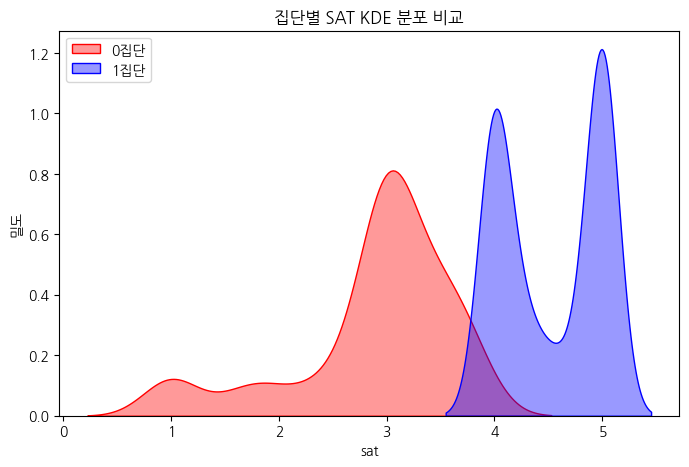

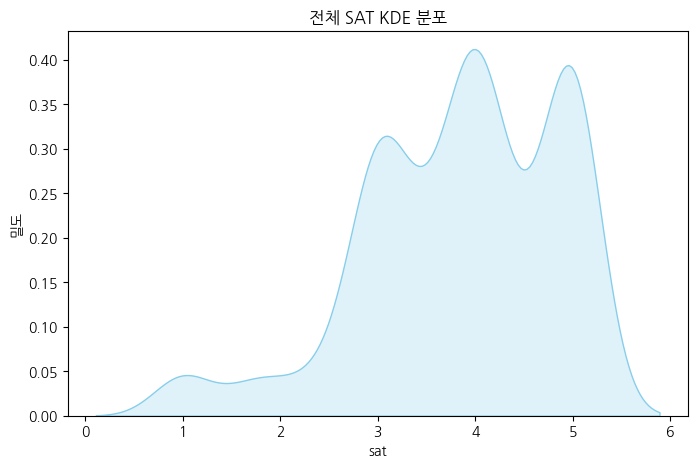

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# ✅ 한글 폰트 설정 (예: 나눔고딕)
plt.rcParams['font.family'] = 'NanumGothic'   # 설치된 다른 한글 폰트 가능
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 깨짐 방지

# KDE 그리기
plt.figure(figsize=(8, 5))
sns.kdeplot(group0, fill=True, color="red", alpha=0.4, label="0집단")
sns.kdeplot(group1, fill=True, color="blue", alpha=0.4, label="1집단")
plt.title("집단별 SAT KDE 분포 비교")
plt.xlabel("sat")
plt.ylabel("밀도")
plt.legend()
plt.show()


# 전체 sat KDE 분포
plt.figure(figsize=(8, 5))
sns.kdeplot(df['sat'], fill=True, color="skyblue")
plt.title("전체 SAT KDE 분포")
plt.xlabel("sat")
plt.ylabel("밀도")
plt.show()


In [4]:
# ======================================
# ✅ 최적화 버전: ElasticNet + RFECV(LR/DT/RF/XGB)
# - 변수 선택은 항상 X_train 내부에서 수행
# - 폴드별 선택 변수 → 교집합(안정적 변수) 추출
# - CV(파이프라인 전체) & Hold-out 평가
# - 중복 코드 최소화, 가독성 강화
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

# -------------------------
# 설정
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 존재 확인
# -------------------------
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

# -------------------------
# 타깃/설명변수 설정
# -------------------------
target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

# -------------------------
# 학습/테스트 분할
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# CV 설정
# -------------------------
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# -------------------------
# RFECV 파이프라인 생성 함수 
# -------------------------
def make_rfecv_pipeline(base_estimator, final_estimator=None):
    """RFECV 기반 파이프라인 생성"""
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1,
        verbose=0
    )
    # LogisticRegression일 때만 스케일러 추가
    if isinstance(base_estimator, LogisticRegression):
        return Pipeline([("scaler", StandardScaler()),
                         ("feature_selection", rfecv),
                         ("clf", final_estimator)])
    else:
        return Pipeline([("feature_selection", rfecv),
                         ("clf", final_estimator)])

# -------------------------
# 모델 정의
# -------------------------
models = {
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
            l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# -------------------------
# 폴드별 선택 변수 추출
# -------------------------
def extract_fold_selected(pipe_name, pipe):
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]

        if pipe_name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[enet_fold.coef_.ravel() != 0])
        else:
            # RFECV 모델
            base_map = {
                "RFECV_LR": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                "RFECV_DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
                "RFECV_RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                "RFECV_XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                           eval_metric='logloss', n_jobs=-1)
            }
            rfecv_fold = RFECV(
                estimator=base_map[pipe_name], step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
                n_jobs=1
            )
            rfecv_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    return fold_sets

selected_per_model = {name: extract_fold_selected(name, pipe) for name, pipe in models.items()}

# -------------------------
# Jaccard 안정성 지수
# -------------------------
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2: return np.nan
    scores = []
    from itertools import combinations
    for i,j in combinations(range(len(list_of_sets)),2):
        a, b = list_of_sets[i], list_of_sets[j]
        scores.append(1.0 if len(a|b)==0 else len(a&b)/len(a|b))
    return np.mean(scores)

# -------------------------
# CV & Hold-out 평가
# -------------------------
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring,
                            n_jobs=-1, error_score=np.nan)
    cv_mean = {m: np.nanmean(cv_res[f"test_{m}"]) for m in scoring.keys()}
    cv_std = {m: np.nanstd(cv_res[f"test_{m}"]) for m in scoring.keys()}

    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        try: y_score = fitted_pipe.decision_function(X_test)
        except: y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()
    jacc = mean_pairwise_jaccard(fold_sets)

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['feature_selection'].support_])
        except: final_selected = []
    elif name == "ElasticNet":
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel()!=0])
        except: final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(list(stable_vars)),
        "final_selected": sorted(final_selected)
    })

# -------------------------
# 결과 정리
# -------------------------
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "n_stable_vars": len(r["stable_vars"]),
        "stable_vars": ", ".join(r["stable_vars"]),
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "Jaccard": r["jaccard"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== 요약 표 ===")
display(summary_df)

for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    print("안정적 변수:" + (", ".join(r['stable_vars']) if r['stable_vars'] else " 없음"))
    print(f"최종 선택 변수 수: {len(r['final_selected'])}")
    print("최종 선택 변수:" + (", ".join(r['final_selected']) if r['final_selected'] else " 없음"))



===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 요약 표 ===


,model,n_stable_vars,stable_vars,CV_f1_mean,CV_acc_mean,CV_roc_mean,Holdout_f1,Holdout_acc,Holdout_roc,Jaccard
4,RFECV_XGB,7,"exp_concours, fit_major, learn_fun, peer_event...",0.907971,0.894849,0.952976,0.950495,0.943182,0.974033,0.364568
3,RFECV_RF,58,"admin_serv, ask_q, car_spt, change_career, cha...",0.906179,0.891871,0.973304,0.952381,0.943182,0.982512,0.688186
1,RFECV_LR,22,"admin_serv, drop_out, enter_type_early, enter_...",0.891111,0.877907,0.906758,0.932039,0.920455,0.937997,0.438911
0,ElasticNet,17,"admin_serv, change_major, course_variety, fit_...",0.890279,0.875010,0.921981,0.932039,0.920455,0.936407,0.373826
2,RFECV_DT,2,"peer_external, prof_passion",0.881937,0.863380,0.860394,0.912621,0.897727,0.898516,0.250375



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수:admin_serv, change_major, course_variety, fit_major, move_univ, peer_career, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff
최종 선택 변수 수: 152
최종 선택 변수:abroad_practice, admin_serv, ask_q, birth_area_abroad, birth_area_chungcheong, birth_area_gangwon, birth_area_honam, birth_area_seoul, birth_area_yeongnam, burnout, car_spt, career_course, change_career, change_major, cont_major, course_variety, dance_years, drink_freq, drop_out, enter_type_early, enter_type_regular, enter_type_transfer, exercise_reg, exp_broadcast, exp_concours, exp_group_comp, exp_perf, exp_solo_comp, exp_video, field_practice, find_data, fit_major, gender, go_abroad, go_grad, grade, has_future_job, has_income, has_major_income, housing_culture, housing_edu, housing_green, housing_hygiene, housing_infra, housing_safety, housing_transit, housing_type_dormitory, housing_type_

In [30]:
# ======================================
# ✅ RFECV_XGB 안정적 변수 기반 모델링
# ======================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef
)
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1️⃣ 기본 설정
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# df가 이미 존재한다고 가정
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

target_col = "sat_group"
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# 2️⃣ RFECV_XGB에서 도출된 안정적 변수 입력
# -------------------------
rfecv_xgb_stable_vars = ['exp_concours', 'fit_major', 'learn_fun', 'peer_event', 'prof_passion', 'student_interact', 'students_diligent']
   

print(f"✅ RFECV_XGB 안정적 변수 {len(rfecv_xgb_stable_vars)}개 사용:", rfecv_xgb_stable_vars)

# -------------------------
# 3️⃣ 모델 정의
# -------------------------
final_models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))
    ]),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(
        n_estimators=200, random_state=RANDOM_STATE,
        use_label_encoder=False, eval_metric='logloss', n_jobs=-1
    )
}

# -------------------------
# 4️⃣ 교차검증 및 홀드아웃 평가
# -------------------------
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

results_final = []
for name, model in final_models.items():
    print(f"\n===== 모델 평가 중: {name} =====")
    Xtr = X_train[rfecv_xgb_stable_vars]
    Xte = X_test[rfecv_xgb_stable_vars]

    # CV 성능
    cv_res = cross_validate(model, Xtr, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1)
    cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out 성능
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    try:
        y_score = model.predict_proba(Xte)[:, 1]
    except:
        y_score = model.decision_function(Xte)

    holdout = {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_acc": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score),
        "mcc": matthews_corrcoef(y_test, y_pred)
    }

    results_final.append({
        "model": name,
        "n_features": len(rfecv_xgb_stable_vars),
        **{f"CV_{k}_mean": cv_mean[k] for k in scoring},
        **{f"CV_{k}_std": cv_std[k] for k in scoring},
        **{f"Test_{k}": v for k, v in holdout.items()}
    })

# -------------------------
# 5️⃣ 결과 요약표
# -------------------------
results_final_df = pd.DataFrame(results_final).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== RFECV_XGB 안정적 변수 기반 성능표 ===")
display(results_final_df)


✅ RFECV_XGB 안정적 변수 7개 사용: ['exp_concours', 'fit_major', 'learn_fun', 'peer_event', 'prof_passion', 'student_interact', 'students_diligent']

===== 모델 평가 중: LogReg =====

===== 모델 평가 중: DT =====

===== 모델 평가 중: RF =====

===== 모델 평가 중: XGB =====


=== RFECV_XGB 안정적 변수 기반 성능표 ===


,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,Test_mcc
2,RF,7,0.906197,0.918898,0.952591,0.026487,0.022417,0.033292,0.931818,0.926338,0.942308,0.924528,0.960784,0.980392,0.859999
3,XGB,7,0.900443,0.914093,0.948395,0.039562,0.033225,0.031863,0.897727,0.893217,0.912621,0.903846,0.921569,0.951245,0.789578
1,DT,7,0.889256,0.905516,0.891914,0.038581,0.030250,0.058659,0.909091,0.903021,0.923077,0.905660,0.941176,0.926073,0.812964
0,LogReg,7,0.869497,0.889420,0.921825,0.052764,0.042646,0.038488,0.840909,0.821940,0.872727,0.813559,0.941176,0.926338,0.676185


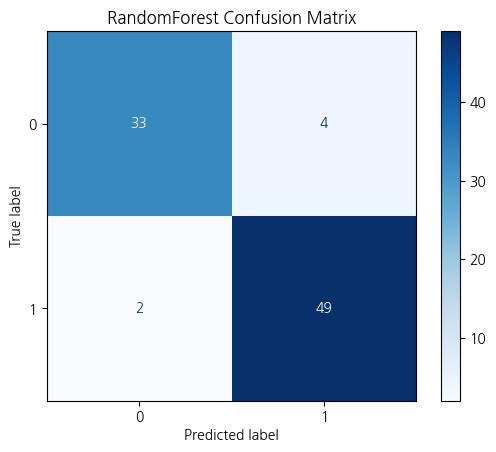


📊 RandomForest 변수 중요도:


,feature,importance
4,prof_passion,0.223945
3,peer_event,0.169105
6,students_diligent,0.163669
2,learn_fun,0.150509
5,student_interact,0.132639
1,fit_major,0.109793
0,exp_concours,0.050341


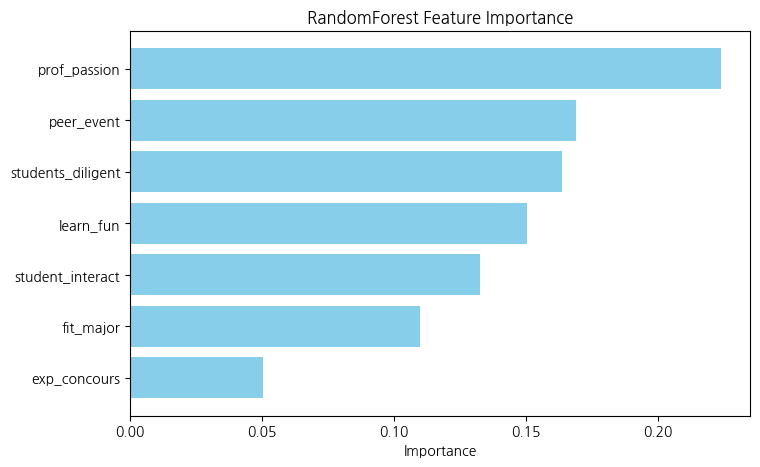

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ RandomForest 모델 학습
# -------------------------
rf_model = final_models['RF']
Xtr = X_train[rfecv_xgb_stable_vars]
Xte = X_test[rfecv_xgb_stable_vars]

rf_model.fit(Xtr, y_train)
y_pred = rf_model.predict(Xte)

# -------------------------
# 2️⃣ 혼동행렬 시각화
# -------------------------
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("RandomForest Confusion Matrix")
plt.show()

# -------------------------
# 3️⃣ 변수 중요도 분석
# -------------------------
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": rfecv_xgb_stable_vars,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n📊 RandomForest 변수 중요도:")
display(feature_importance_df)

# 막대그래프로 시각화
plt.figure(figsize=(8,5))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("RandomForest Feature Importance")
plt.show()


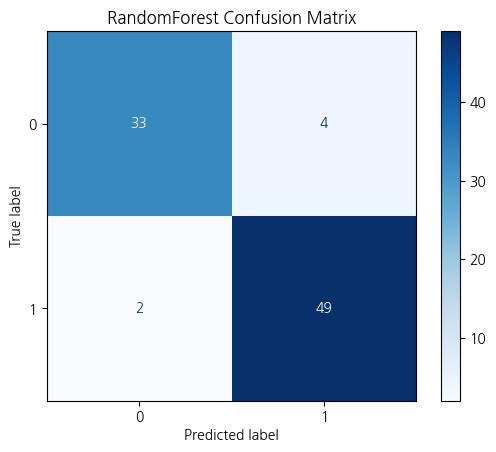

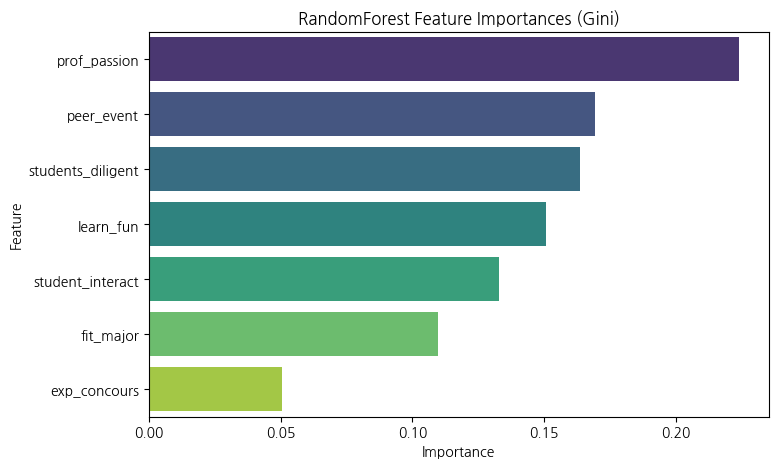


Classification Report:

              precision    recall  f1-score   support

           0     0.9429    0.8919    0.9167        37
           1     0.9245    0.9608    0.9423        51

    accuracy                         0.9318        88
   macro avg     0.9337    0.9263    0.9295        88
weighted avg     0.9322    0.9318    0.9315        88



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -------------------------
# RandomForest 모델 학습
# -------------------------
rf_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train[rfecv_xgb_stable_vars], y_train)
y_pred = rf_model.predict(X_test[rfecv_xgb_stable_vars])

# -------------------------
# 1️⃣ 혼동행렬
# -------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("RandomForest Confusion Matrix")
plt.show()

# -------------------------
# 2️⃣ 변수 중요도
# -------------------------
importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=rfecv_xgb_stable_vars).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette='viridis')
plt.title("RandomForest Feature Importances (Gini)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# -------------------------
# 3️⃣ 정밀도, 재현율, F1
# -------------------------
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


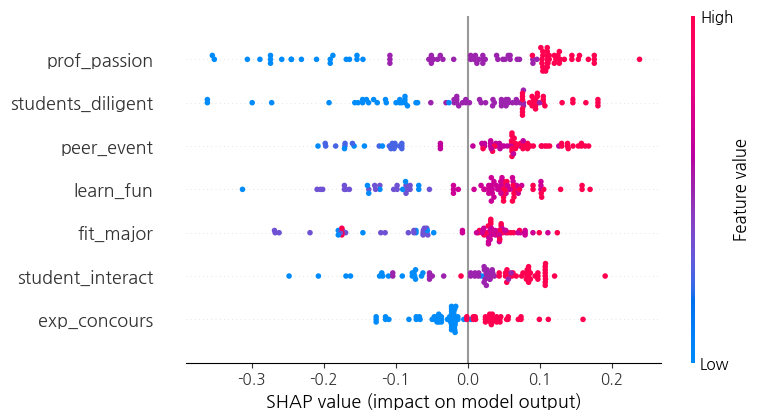

In [45]:
import shap
import matplotlib.pyplot as plt

# TreeExplainer 생성
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test[rfecv_xgb_stable_vars])

# shap_values는 Explanation 객체 -> .values 사용
# 2차원: (n_samples, n_features)
# 이진 분류는 shap_values.values.shape = (n_samples, n_features, n_classes)
# positive class 기준
shap_values_pos = shap_values.values[:, :, 1]  # 1: positive class

# Summary plot (dotplot) - 모든 변수 표시
shap.summary_plot(
    shap_values_pos,
    X_test[rfecv_xgb_stable_vars],
    plot_type="dot",
    max_display=7
)


In [46]:
for i, col in enumerate(rfecv_xgb_stable_vars):
    print(col, "SHAP mean abs:", abs(shap_values.values[:, i]).mean())


exp_concours SHAP mean abs: 0.041262213182507806
fit_major SHAP mean abs: 0.07177251901772168
learn_fun SHAP mean abs: 0.0815350141087082
peer_event SHAP mean abs: 0.09035763154105438
prof_passion SHAP mean abs: 0.12175466985300742
student_interact SHAP mean abs: 0.07103341820345405
students_diligent SHAP mean abs: 0.09261530563102616
